# AWD-LSTM (ULMFit)

In this notebook we train an AWD-LSTM model for the proxy task with language model pretraining on IMSLP and language model fine-tuning on the target data.  This notebook has been adapted from the fast.ai [ULMFit tutorial](https://github.com/fastai/course-nlp/blob/master/nn-vietnamese.ipynb).

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
import glob
import eval_models

In [21]:
bs=48

In [22]:
torch.cuda.set_device(0)

In [23]:
data_path = Config.data_path()

In [24]:
name = 'solo_bscore_lm'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

### IMSLP Language Model

In [25]:
data = load_data(path, 'solo_lm_all_databunch', bs=bs)

In [26]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [8]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 8.32E-03


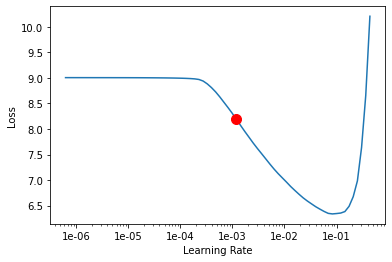

In [9]:
learn.recorder.plot(suggestion=True)

In [13]:
lr = 1e-3

In [14]:
learn.unfreeze()
learn.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.374655,3.289169,0.225215,02:31
1,2.978145,2.958840,0.305043,02:33
2,2.992476,2.823904,0.335085,02:33
3,2.695225,2.764270,0.349103,02:33
4,2.703622,2.722916,0.357887,02:32
5,2.662319,2.694435,0.365111,02:32
6,2.627836,2.680061,0.368412,02:33
7,2.583837,2.677022,0.369194,02:33


In [18]:
learn.fit_one_cycle(3, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.835981,2.883918,0.325464,02:31
1,2.937948,2.823506,0.338540,02:36
2,2.867607,2.800894,0.343650,02:35


In [27]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True, parents=True)

In [28]:
model_basename = 'awdlstm_train-all_lm'
# learn.save(mdl_path/f'{model_basename}_wt', with_opt=False)
# learn.data.vocab.save(mdl_path/f'{model_basename}_vocab.pkl')

### Finetune Language Model

In [29]:
data_target_lm = load_data(path, 'solo_lm_target_databunch', bs=bs)

In [30]:
lm_fns = [mdl_path/f'{model_basename}_wt', mdl_path/f'{model_basename}_vocab']
learn_lm = language_model_learner(data_target_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [19]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-05
Min loss divided by 10: 3.31E-03


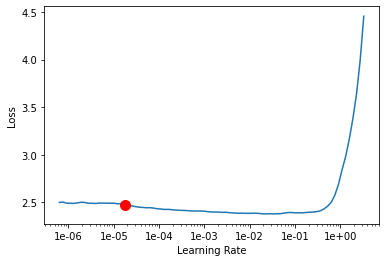

In [20]:
learn_lm.recorder.plot(suggestion=True)

In [21]:
lr = 1e-3

In [22]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.436598,2.414826,0.376923,01:17
1,2.303451,2.396038,0.379779,01:18


In [23]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.349253,2.408618,0.376138,01:17
1,2.420698,2.442538,0.368216,01:19
2,2.407464,2.439741,0.369129,01:19
3,2.251931,2.433525,0.370827,01:19
4,2.179138,2.423472,0.374250,01:19
5,2.258566,2.412134,0.377226,01:19
6,2.378371,2.406523,0.379085,01:20
7,2.277710,2.404756,0.379978,01:19


In [24]:
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.327704,2.411097,0.377448,01:15
1,2.275454,2.437909,0.371507,01:17
2,2.311932,2.439316,0.371680,01:18
3,2.236418,2.436617,0.372050,01:18
4,2.365329,2.428766,0.374983,01:18
5,2.099770,2.425408,0.377670,01:18
6,2.193305,2.421324,0.378989,01:19
7,2.091573,2.422706,0.379196,01:18


In [31]:
ftmodel_basename = 'awdlstm_train-all_finetune-target_lm'
# learn_lm.save(ftmodel_basename)
# learn_lm.save_encoder(f'{ftmodel_basename}enc')

### Train Classifier

In [47]:
train_df = pd.read_csv(path/'train256.csv')
valid_df = pd.read_csv(path/'valid256.csv')
test_df = pd.read_csv(path/'test256.csv')

In [48]:
basicTokenizer = Tokenizer(pre_rules=[], post_rules=[])
data_clas = TextDataBunch.from_df(path, train_df, valid_df, tokenizer=basicTokenizer,
                                  vocab = data_target_lm.vocab, bs=bs, num_workers=1)

In [49]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy, FBeta(average='macro', beta=1)])
learn_c.load_encoder(f'{ftmodel_basename}enc')
learn_c.freeze()

In [19]:
len(learn_c.data.vocab.itos)

4616

In [17]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02
Min loss divided by 10: 2.51E-02


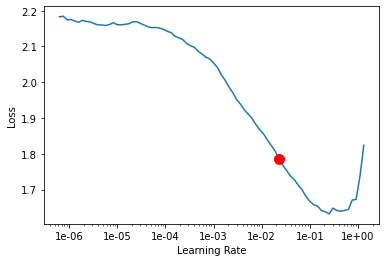

In [18]:
learn_c.recorder.plot(suggestion=True)

In [19]:
lr = 1e-3

In [20]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.896140,1.365712,0.537917,0.533202,02:48
1,0.720968,1.396436,0.540000,0.535099,02:52


In [33]:
learn_c.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.277214,1.584312,0.440625,0.428329,00:44
1,1.257404,1.594135,0.438802,0.434272,00:45
2,1.185317,1.591894,0.439844,0.434538,00:44
3,1.139858,1.595444,0.441406,0.436438,00:44


In [26]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.890200,1.533923,0.490833,0.487089,01:22
1,0.726067,1.626671,0.484948,0.480452,01:25


In [27]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.648694,1.654029,0.477656,0.472151,01:28


In [21]:
learn_c.save('awdlstm_train-imslp_finetune-target_clas_256')

In [50]:
learn_c.load('awdlstm_train-imslp_finetune-target_clas_256')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (28800 items)
x: TextList
xxbos 0 2 4 4 8 8 2 2 2 2 8 2 557056 671744 2138112 512 4096 16384 32768 16384 32768 131072 131074 2048 32768 32768 524288 262145 131074 2 2 524288 65536 131072 1073872896 32768 4096 8192 8192 4096 8192 3145728 524288 1073741824 xxunk 192 256 4194304 8388608 196 2 xxunk 524288 4 67108864 268435497 8 33554432 16 8 16 67108864 67108928 536870912 67108880 536870985 67108880 32 192 134217856 603979776 671088640 512 134217728 671088656 132352 268435488 1342177280 268435460 268435456 20 268435460 xxunk 4 268435460 262144 1073807360 xxunk 1073741824 1073741844 262144 1073872896 xxunk 139264 1073872896 1073741828 2097152 131072 262144 262144 262144 262144 524288 262144 524288 1024 65536 131072 65536 131072 131072 131072 131072 327680 131072 131072 262144 65536 32768 65536 2048 131072 16384 32768 16384 526336 xxunk 164 2048 67110912 xxunk 2048 131072 16779264 xxunk 2048 33556480 xxunk 2048 16779264 687865930 16779264

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [24]:
data_clas_test = TextDataBunch.from_df(path, train_df, test_df, tokenizer=basicTokenizer,
                                       vocab = data_target_lm.vocab, bs=bs, num_workers=1)

In [25]:
learn_c.validate(data_clas_test.valid_dl)

[1.3873215, tensor(0.4951), tensor(0.4963)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.


In [38]:
train_fullpage_df = pd.read_csv(path/'train.fullpage.csv')
valid_fullpage_df = pd.read_csv(path/'valid.fullpage.csv')
test_fullpage_df = pd.read_csv(path/'test.fullpage.csv')

In [25]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_fullpage_df)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.46987950801849365, 0.4457831382751465),
 (0.46684442453687924, 0.4528893246848211))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [51]:
test_ensemble_df = pd.read_csv(path/'test.ensemble256.csv')

In [52]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.5692108869552612, 0.5866752862930298),
 (0.5499971270170205, 0.5563226331779004))

### Error Analysis

In [26]:
interp = ClassificationInterpretation.from_learner(learn_c)

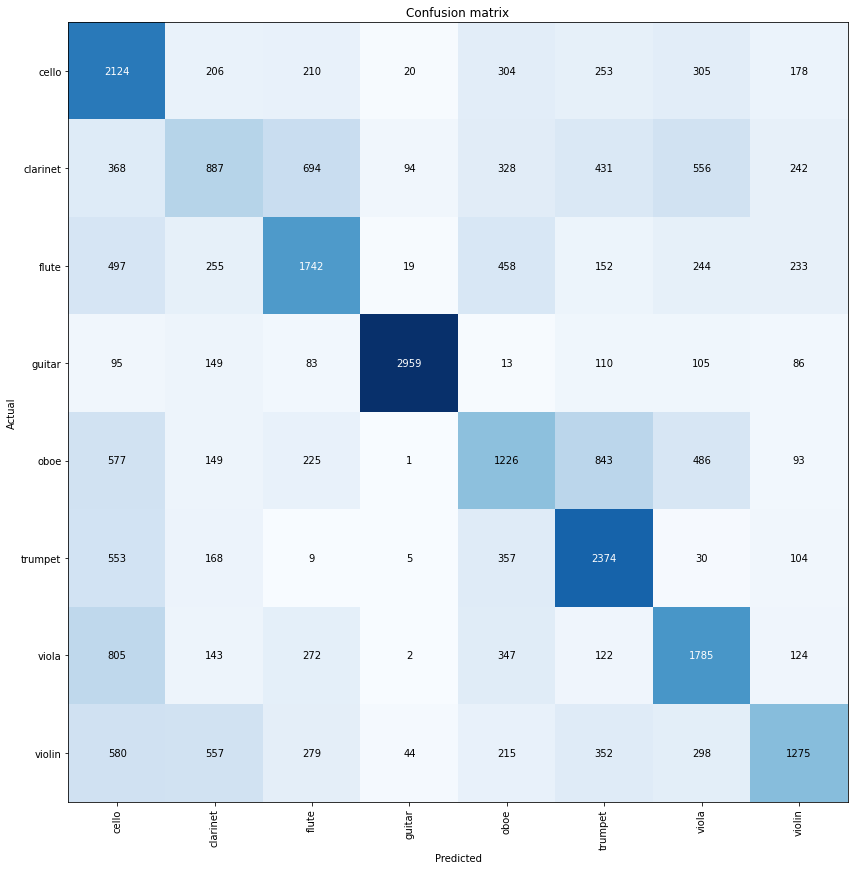

In [27]:
interp.plot_confusion_matrix(figsize=(12,12))